In this experiment section, we want to answer to 3 main questions: 

- Do new features increase the performance of a classifier?
    --> the difference of the performance are statistically significant? 
- Which is the best set of features among the ones described above?
    --> Description of the remanining features, what they focus on?
- Which are the characteristics of the best classifier? 
    - Feature importance
    - Probability distribution 
    - Classification explanation
    - Errors study

Are the features proposed in [3] valid set of features if we consider a larger set of smart-contracts?

We consider the set of smart contracts as the union of the smart contracts made available in the papers [1,2,3] and we evaluate the performance of several classifiers tuning their hyperparameters by means of a grid search and k-fold cross validation procedure. Grid search tests all the possible combinations of values of hyperparameters given in input to the classifier. The k-fold cross validation, instead, splits the training dataset in k folds, and performs the training of the configured classifier on k-1 folds and uses the k-th fold as validation set. Then, the folds are permuted so that everyone is used as validation set. 





In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import shap
import lightgbm as lgb
import glob

In [210]:
plt.rcParams["mathtext.fontset"]

'dejavusans'

In [288]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, auc_score,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.title('AUC Score: {}'.format(auc_score))
    plt.grid(True)                                            
    plt.show()


In [11]:
def best_classifiers_cv(df_cv,data,X_train,y_train,X_test,y_test):
    df_cv['classifier'] = df_cv.param_classifier.apply(lambda x: x.__str__().split('(')[0])
    df_cv['ranking_by_classifier'] = df_cv.sort_values(by='rank_test_score').groupby(['classifier'])['rank_test_score'].cumcount() + 1
    for row in df_cv[df_cv['ranking_by_classifier']==1].iterrows():
        cls = row[1]['param_classifier']
        name_classifier = row[1]['classifier'] 
        print(row[1]['classifier'])
        cls.fit(X_train,y_train.ravel())
        y_pred_train = cls.predict(X_train)
        data['precision_training_{}'.format(name_classifier)] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
        data['recall_training_{}'.format(name_classifier)] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
        data['accuracy_training_{}'.format(name_classifier)] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
        data['f1_training_{}'.format(name_classifier)] = [f1_score(y_train, y_pred_train)]    

        # Confusion matrix 
        y_pred = cls.predict(X_test)
        data['precision_test_{}'.format(name_classifier)] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
        data['recall_test_{}'.format(name_classifier)] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
        data['accuracy_test_{}'.format(name_classifier)] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
        data['f1_test_{}'.format(name_classifier)] = [f1_score(y_test, y_pred)]

        y_pred_proba = cls.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
        auc_score = roc_auc_score(y_test,y_pred_proba)

        data['auc_score_test_{}'.format(name_classifier)] = auc_score

#         plt.figure(figsize=(8, 6))                                    
#         plot_roc_curve(fpr, tpr, auc_score)


In [369]:
def get_grid_search(dataset,name):
    data = {}
    data['test'] = name
    X = dataset.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
    y = dataset.iloc[:, -1:].values

    print(X.shape,y.shape,dataset.columns)

    # divido in train set (TR) e test set (TS)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

    flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
    print('Number of smart contract in train set::', flat_list_train.count(0))
    print('Number of smart Ponzi in train set::', flat_list_train.count(1))
    flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
    print('Number of smart contract in test set::', flat_list_test.count(0))
    print('Number of smart Ponzi in test set::', flat_list_test.count(1))
    pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

    params =[
        {
            'classifier': [DecisionTreeClassifier(random_state=42)],
            'classifier__criterion' : ['entropy', 'gini'],
            'classifier__max_depth' : [5, 6, 7, 8, 9],
            'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
            'classifier__max_features' : range(6,X_train.shape[1],3),
            'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        },
        {
            'classifier': [RandomForestClassifier(random_state=42)],
            'classifier__n_estimators':[150, 175, 200, 225, 250],
            'classifier__min_samples_split' : [5,15,30],
            'classifier__criterion':['gini', 'entropy'],
            'classifier__class_weight' : [{0:1, 1:5.5}],
            'classifier__bootstrap': [True, False]
        },
    #     {
    #         'classifier': [SVC(random_state=42,probability=True)],            
    #         'classifier__kernel' : ["poly"],
    #         'classifier__C' : [0.1,1,5,10],
    #         'classifier__coef0' : [1,0.8],
    #         'classifier__gamma': ['auto']

    #     },
        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1,0.01],
            'classifier__n_estimators' : [80, 100, 120],
            'classifier__max_depth' : [10,15,20],
            'classifier__colsample_bytree' : [0.5,0.8,1],
            'classifier__reg_alpha' : [0, 0.1, 0.2],
            'classifier__reg_lambda' : [1,10,15]
        }



         ]
    grid_search = GridSearchCV(pipeline, params, cv=5,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
    grid_search.fit(X_train, y_train.ravel())

    data['best hyperparameters'] = [grid_search.best_params_]
    data['best score'] = [grid_search.best_score_]

    y_pred_train = grid_search.best_estimator_.predict(X_train)
    data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
    data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
    data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
    data['best_f1_training'] = [f1_score(y_train, y_pred_train)]    

    # Confusion matrix 
    y_pred = grid_search.best_estimator_.predict(X_test)
    data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
    data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
    data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
    data['best_f1_test'] = [f1_score(y_test, y_pred)]


In [370]:
path = '../paper_3_features'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
target_path = glob.glob(path+"/target*.csv")[0]
dataset_paper = pd.read_csv(dataset_path, header = 0)

target = pd.read_csv(target_path, header = 0)

df_dataset = pd.concat([dataset_paper,target],axis=1).drop_duplicates(subset='address')
grid_search_paper,data_paper = get_grid_search(df_dataset,'paper')

(4422, 13) (4422, 1) Index(['address', 'balance', 'N_maxpayment', 'investment_in', 'payment_out',
       'mean_v1', 'sdev_v1', 'skew_v1', 'mean_v2', 'sdev_v2', 'skew_v2',
       'known_rate', 'paid_rate', 'paid_one', 'target'],
      dtype='object')
Number of smart contract in train set:: 2999
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 750
Number of smart Ponzi in test set:: 135
Fitting 5 folds for each of 726 candidates, totalling 3630 fits
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(ra

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), class


[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(ra

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(r

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42)

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.5s
[CV] END classifier=RandomForestClas

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.5s
[CV] END classifier=Rand

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.7s
[CV] END classifier=RandomForestClas

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=225; total time=   0.8s
[CV] END classifier=Rand

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__re

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_la

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__re

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=  

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total ti

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total tim

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; tot

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; to

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total t

TypeError: cannot unpack non-iterable NoneType object

In [506]:
grid_search_paper.best_params_

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_jobs=4, random_state=42,
                reg_alpha=0.1, reg_lambda=10),
 'classifier__colsample_bytree': 0.5,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 15,
 'classifier__n_estimators': 100,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 10}

In [507]:
grid_search_full.best_params_

{'classifier': LGBMClassifier(colsample_bytree=0.8, max_depth=20, n_estimators=80, n_jobs=4,
                random_state=42, reg_alpha=0.2, reg_lambda=1),
 'classifier__colsample_bytree': 0.8,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 20,
 'classifier__n_estimators': 80,
 'classifier__reg_alpha': 0.2,
 'classifier__reg_lambda': 1}

In [371]:
df_results = pd.DataFrame(data_paper)

In [444]:
path = '../dataset full/'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
target_path = glob.glob(path+"/target*.csv")[0]
dataset_full = pd.read_csv(dataset_path, header = 0)

# leggo il dataset ed il target

target = pd.read_csv(target_path, header = 0)

df_dataset_full = pd.concat([dataset_full,target],axis=1).drop_duplicates(subset='address')
grid_search_full, data_paper_full = get_grid_search(df_dataset_full,'full_dataset')

In [373]:
df_results = pd.concat([df_results,pd.DataFrame(data_paper_full)])

In [374]:
df_melted = pd.melt(df_results,id_vars='test',value_vars=['precision_test_DecisionTreeClassifier',
       'recall_test_DecisionTreeClassifier',
       'accuracy_test_DecisionTreeClassifier',
       'f1_test_DecisionTreeClassifier',
       'auc_score_test_DecisionTreeClassifier','precision_test_RandomForestClassifier',
       'recall_test_RandomForestClassifier',
       'accuracy_test_RandomForestClassifier',
       'f1_test_RandomForestClassifier',
       'auc_score_test_RandomForestClassifier','precision_test_LGBMClassifier', 'recall_test_LGBMClassifier',
       'accuracy_test_LGBMClassifier', 'f1_test_LGBMClassifier',
       'auc_score_test_LGBMClassifier'],var_name='metric_classifier',value_name='score')

In [375]:
df_melted['classifier'] = df_melted['metric_classifier'].apply(lambda x: x.split('_')[-1])
df_melted['metric'] = df_melted['metric_classifier'].apply(lambda x: x.split('_')[0])

In [376]:
df_pivot = df_melted.pivot(index=['test','classifier'],columns='metric',values='score').sort_values(['test','classifier','auc'])

In [377]:
df_pivot

metric                               accuracy       auc        f1  precision  \
test         classifier                                                        
full_dataset DecisionTreeClassifier  0.855367  0.733279  0.496063   0.529412   
             LGBMClassifier          0.903955  0.883136  0.608295   0.804878   
             RandomForestClassifier  0.896045  0.875165  0.561905   0.786667   
paper        DecisionTreeClassifier  0.861017  0.674430  0.481013   0.558824   
             LGBMClassifier          0.875706  0.787551  0.444444   0.698413   
             RandomForestClassifier  0.873446  0.770479  0.461538   0.657534   

metric                                 recall  
test         classifier                        
full_dataset DecisionTreeClassifier  0.466667  
             LGBMClassifier          0.488889  
             RandomForestClassifier  0.437037  
paper        DecisionTreeClassifier  0.422222  
             LGBMClassifier          0.325926  
             RandomForestClassifier  0.355556

In [202]:
s = df_pivot.to_latex(float_format="%.3f")
with open('comparison_table.tex','w') as fout:
    fout.write(s)

In [284]:
from mlxtend.evaluate import mcnemar,mcnemar_table

In [285]:
from statsmodels.stats.contingency_tables import mcnemar as stats_mcnemar

In [172]:
def get_split(df):
    X = df.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
    y = df.iloc[:, -1:].values

# divido in train set (TR) e test set (TS)
    return train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 
    


In [277]:
X_train_full, X_test_full, y_train_full, y_test_full = get_split(df_dataset_full)
X_train_paper, X_test_paper, y_train_paper, y_test_paper = get_split(df_dataset )


In [278]:
print(X_train_full.shape[0],X_test_full.shape[0])

3537 885


In [279]:
y_pred_paper = grid_search_paper.best_estimator_.predict(X_test_paper)
y_pred_full = grid_search_full.best_estimator_.predict(X_test_full)


In [280]:
print(X_train_paper.shape[0],X_test_paper.shape[0])

3537 885


In [281]:
mc_t = mcnemar_table(y_test_full.ravel(),y_pred_paper,y_pred_full)

In [282]:
mc_t

array([[762,  13],
       [ 38,  72]])

In [286]:
mcnemar(mc_t,corrected=True)

(11.294117647058824, 0.0007775304469403848)

In [287]:
threshold = 3.841 
significance_value = 0.05

# McNemar's Test with the continuity correction
test = stats_mcnemar(mc_t, exact=False, correction=True)

if test.pvalue < significance_value:
    print("Reject Null hypotesis")
else:
    print("Fail to reject Null hypotesis")

#or equivalently
if test.statistic > threshold:
    print("Reject Null hypotesis")
else:
    print("Fail to reject Null hypotesis")

Reject Null hypotesis
Reject Null hypotesis


In [295]:
plt.rcParams.update(plt.rcParamsDefault)

In [383]:
auc_score_full

0.8831358024691358

In [465]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

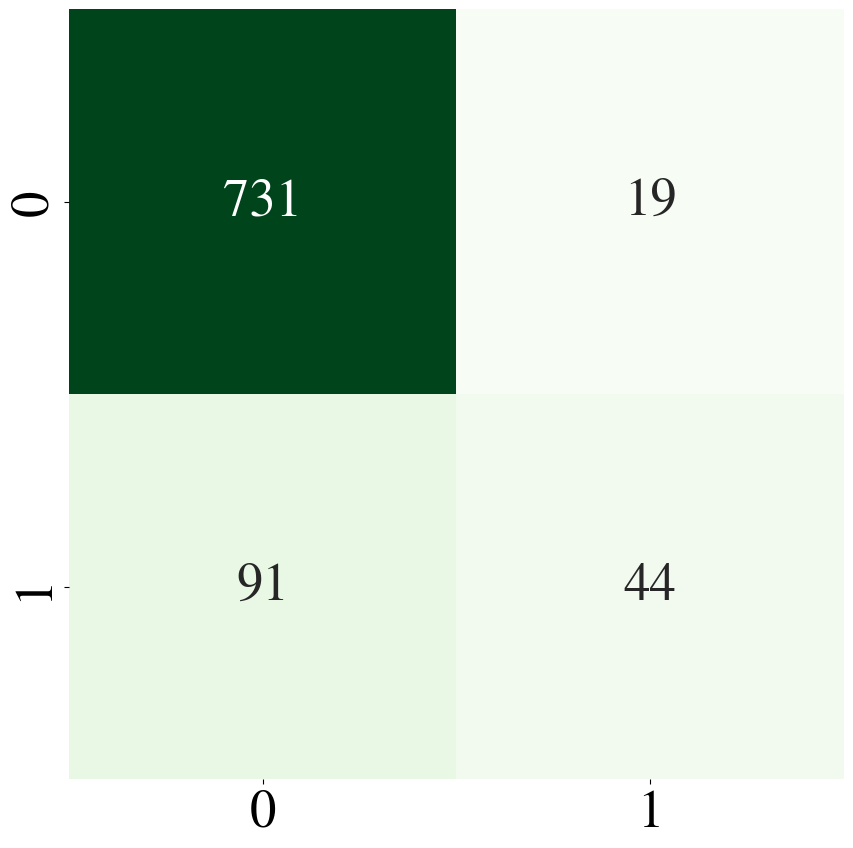

In [466]:
### Matrici di confusione

plot_confusion_matrix(y_test_paper, y_pred_paper,'paper')


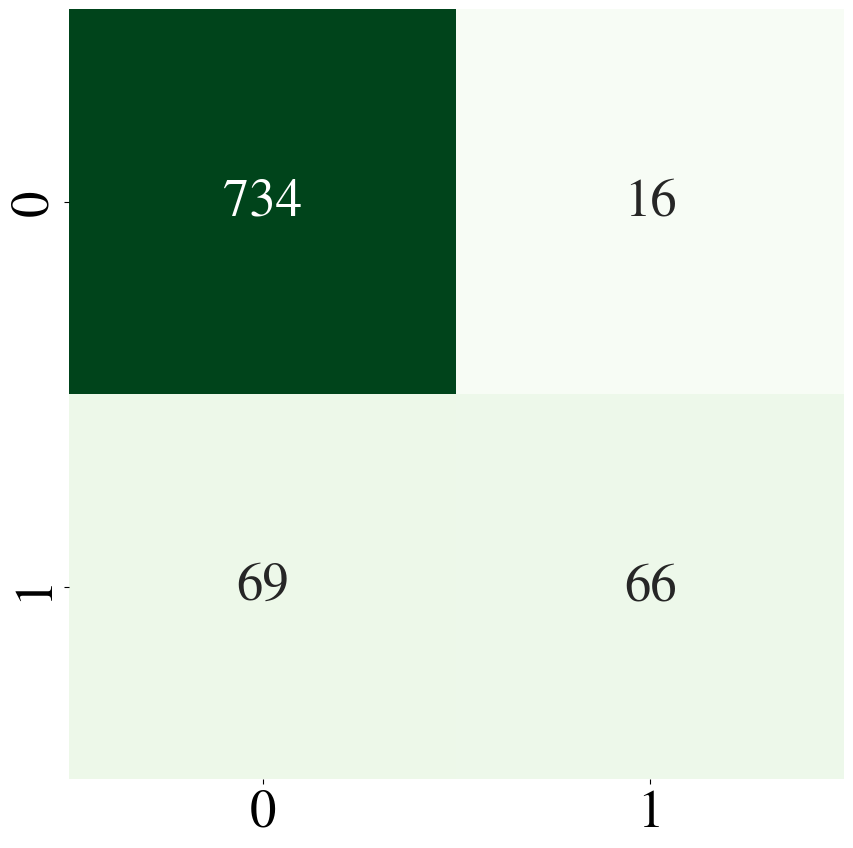

In [467]:
plot_confusion_matrix(y_test_full, y_pred_full,'full')


In [305]:
all_features = {c:0 for c in df_dataset_full.columns[1:-1]}

In [307]:
all_features = {'balance': 0,
 'lifetime': 0,
 'tx_in': 0,
 'tx_out': 0,
 'investment_in': 0,
 'payment_out': 0,
 'investment_to_contract/tx_in': 1,
 'payment_from_contract/tx_out': 1,
 '#addresses_paying_contract': 0,
 '#addresses_paid_by_contract': 0,
 'mean_v1': 0,
 'sdev_v1': 0,
 'mean_v2': 0,
 'sdev_v2': 0,
 'paid_rate': 0,
 'paid_one': 0,
 'percentage_some_tx_in': 1,
 'sdev_tx_in': 1,
 'percentage_some_tx_out': 1,
 'sdev_tx_out': 1,
 'known_rate': 0,
 'owner_gets_eth_Wo_investing': 1,
 'owner_gets_eth_investing': 1,
 'owner_no_eth': 1,
 'skew_v1': 0,
 'N_maxpayment': 0,
 'skew_v2': 0}

In [440]:
all_features_names = {'balance': 'Balance',
 'lifetime': 'Lifetime',
 'tx_in': 'Tx_in',
 'tx_out': 'Tx_out',
 'investment_in': 'Investment_in',
 'payment_out': 'Payment_out',
 'investment_to_contract/tx_in': 'Investment_in/Tx_in',
 'payment_from_contract/tx_out': 'Payment_out/Tx_out',
 '#addresses_paying_contract': '#addresses_paying_contract',
 '#addresses_paid_by_contract': '#addresses_paid_by_contract',
 'mean_v1': 'Mean_v1',
 'sdev_v1': 'Sdev_v1',
 'mean_v2': 'Mean_v2',
 'sdev_v2': 'Sdev_v2',
 'paid_rate': 'Paid_rate',
 'paid_one': 'Paid_one',
 'percentage_some_tx_in': 'Percentage_some_tx_in',
 'sdev_tx_in': 'Sdev_tx_in',
 'percentage_some_tx_out': 'Percentage_some_tx_out',
 'sdev_tx_out': 'Sdev_tx_out',
 'known_rate': 'Known_rate',
 'owner_gets_eth_Wo_investing': 'Initiator_gets_eth_Wo_investing',
 'owner_gets_eth_investing': 'Initiator_gets_eth_investing',
 'owner_no_eth': 'Initiator_no_eth',
 'skew_v1': 'Skew_v1',
 'N_maxpayment': 'N_maxpayment',
 'skew_v2': 'Skew_v2'
}

In [334]:
def clean_labels(labels):
    r_labels = []
    for l in labels:
        t = l.split('_')
        res = l
        if len(t)>2:
            res = t[0]+'_'+t[1]+'\n'+'_'.join(t[2:])
        r_labels.append(res)
    return r_labels
            

In [517]:
def plot_feature_importances(df,grid_search,name,all_features_names,only_new=False):
    if only_new:
        features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
        feature_names = df.columns[1:-1]
        sorted_feat_imp = sorted(zip(feature_importances, feature_names), reverse=False)
        print(sorted_feat_imp)

        labels = [all_features_names[n[1]] for n in sorted_feat_imp if all_features[n[1]]]
        values = [n[0] for n in sorted_feat_imp if all_features[n[1]]]

        labels = clean_labels(labels)
        print(labels)
        plt.figure(figsize=(10,7))
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel('Feature importance',fontsize=18)
        barlist = plt.barh(y=labels,width=values)
#         for i,l in enumerate(labels):
#             if all_features[l.replace('\n','_')]:
#                 barlist[i].set_color('r')
        plt.tight_layout()
        plt.savefig('feat_imp_{}.png'.format(name))
        plt.show()
        
        
    else: 
        features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
        feature_names = df.columns[1:-1]
        sorted_feat_imp = sorted(zip(feature_importances, feature_names), reverse=False)
        print(sorted_feat_imp)

        labels = [all_features_names[n[1]] for n in sorted_feat_imp[-13:]]
        values = [n[0] for n in sorted_feat_imp[-13:]]

        labels = clean_labels(labels)
        print(labels)
        plt.figure(figsize=(10,10))
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel('Feature importance',fontsize=18)
        barlist = plt.barh(y=labels,width=values)
        for i,l in enumerate(labels):
            if all_features[l.replace('\n','_')]:
                barlist[i].set_color('r')
        plt.savefig('feat_imp_{}.png'.format(name))
        plt.show()

[(12, 'owner_gets_eth_investing'), (12, 'owner_no_eth'), (16, 'payment_from_contract/tx_out'), (19, 'payment_out'), (22, 'owner_gets_eth_Wo_investing'), (28, 'tx_out'), (34, '#addresses_paying_contract'), (36, 'investment_in'), (45, 'mean_v2'), (46, 'N_maxpayment'), (50, 'sdev_tx_out'), (53, 'known_rate'), (59, '#addresses_paid_by_contract'), (62, 'paid_rate'), (77, 'skew_v1'), (78, 'paid_one'), (96, 'percentage_some_tx_out'), (97, 'sdev_v1'), (99, 'balance'), (108, 'skew_v2'), (149, 'mean_v1'), (172, 'investment_to_contract/tx_in'), (176, 'sdev_v2'), (195, 'percentage_some_tx_in'), (210, 'lifetime'), (219, 'tx_in'), (230, 'sdev_tx_in')]
['Initiator_gets\neth_investing', 'Initiator_no\neth', 'Payment_out/Tx\nout', 'Initiator_gets\neth_Wo_investing', 'Sdev_tx\nout', 'Percentage_some\ntx_out', 'Investment_in/Tx\nin', 'Percentage_some\ntx_in', 'Sdev_tx\nin']


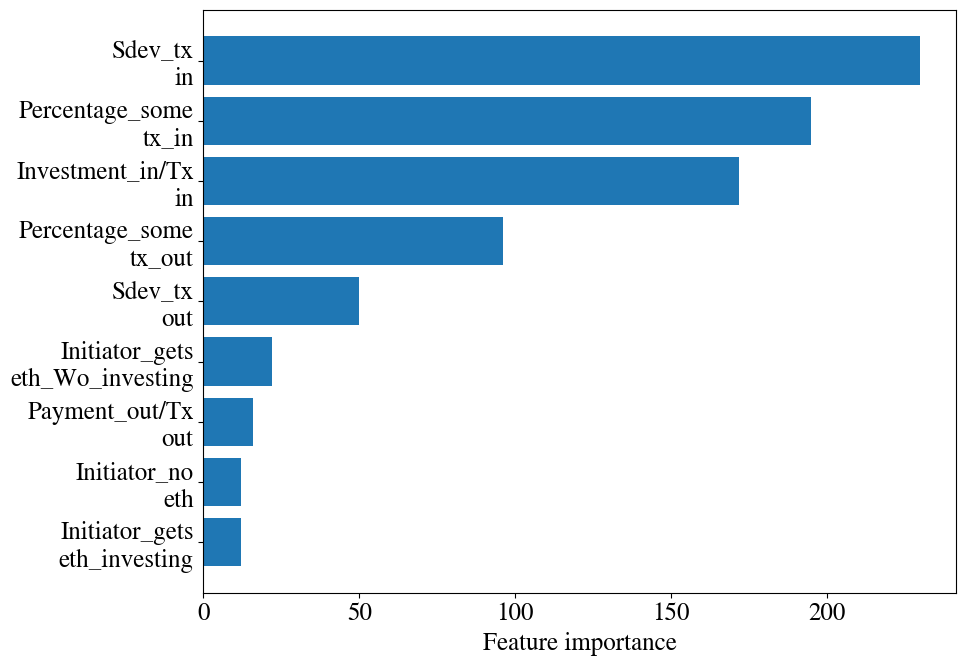

In [518]:
plot_feature_importances(df_dataset_full,grid_search_full,'full',all_features_names,only_new=True)

[(16, 'mean_v2'), (19, 'sdev_v1'), (28, 'payment_out'), (34, 'sdev_v2'), (36, 'mean_v1'), (45, 'paid_one'), (59, 'skew_v2'), (97, 'paid_rate'), (99, 'balance'), (149, 'known_rate'), (172, 'skew_v1'), (210, 'N_maxpayment'), (219, 'investment_in')]


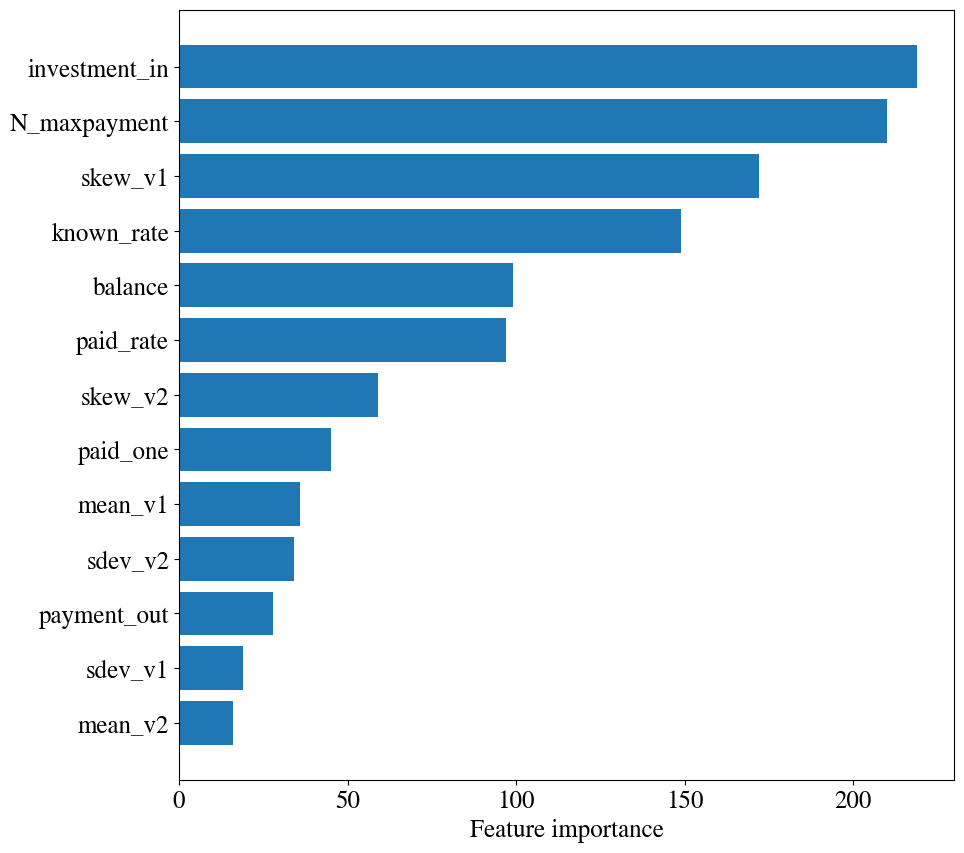

In [327]:
plot_feature_importances(df_dataset,grid_search_paper,'paper')

In [509]:
df_dataset_full.target.value_counts()


0    3749
1     673
Name: target, dtype: int64

In [239]:
df_dataset_full

feature_importances = grid_search_full.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = df_dataset_full.columns[1:-1]

In [250]:
sorted_feat_imp = sorted(zip(feature_importances, feature_names), reverse=False)

In [251]:
labels = [n[1] for n in sorted_feat_imp]
values = [n[0] for n in sorted_feat_imp]

In [357]:
cross_validations = {}

df_cross_validations = pd.DataFrame()

df_X_train_full = pd.DataFrame(X_train_full,columns=df_dataset_full.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test_full,columns=df_dataset_full.columns[1:-1])
model = grid_search_full.best_estimator_
auc_scores = {'n_features':[],'auc_score':[]}
for i in range(len(df_X_train_full.columns),10,-1):
    rfe = RFE(model,n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train.ravel())

# summarize the selection of the attributes
#     print(rfe.support_)
#     print(rfe.ranking_)
    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed,columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed,columns=rfe.get_feature_names_out())
    
    pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

    params =[
        {
            'classifier': [DecisionTreeClassifier(random_state=42)],
            'classifier__criterion' : ['entropy', 'gini'],
            'classifier__max_depth' : [5, 6, 7, 8, 9],
            'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
            'classifier__max_features' : range(6,X_train_transformed.shape[1],3),
            'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        },
        {
            'classifier': [RandomForestClassifier(random_state=42)],
            'classifier__n_estimators':[150, 175, 200, 225, 250],
            'classifier__min_samples_split' : [5,15,30],
            'classifier__criterion':['gini', 'entropy'],
            'classifier__class_weight' : [{0:1, 1:5.5}],
            'classifier__bootstrap': [True, False]
        },
    #     {
    #         'classifier': [SVC(random_state=42,probability=True)],            
    #         'classifier__kernel' : ["poly"],
    #         'classifier__C' : [0.1,1,5,10],
    #         'classifier__coef0' : [1,0.8],
    #         'classifier__gamma': ['auto']

    #     },
        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1,0.01],
            'classifier__n_estimators' : [80, 100, 120],
            'classifier__max_depth' : [10,15,20],
            'classifier__colsample_bytree' : [0.5,0.8,1],
            'classifier__reg_alpha' : [0, 0.1, 0.2],
            'classifier__reg_lambda' : [1,10,15]
        }



     ]
    grid_search = GridSearchCV(pipeline, params, cv=5,
                           scoring='roc_auc',
                           return_train_score=True,n_jobs=4)
    grid_search.fit(df_X_train_full, y_train.ravel())
    cross_validations[i] = grid_search 
    _tmp_cv = pd.DataFrame(grid_search.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out() ])
    
    df_cross_validations = pd.concat([df_cross_validations,_tmp_cv])
    
    model = grid_search.best_estimator_.named_steps['classifier']
    model.fit(df_X_train_full,y_train.ravel())
    y_pred_proba = model.predict_proba(df_X_test_full)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
    auc_score = roc_auc_score(y_test,y_pred_proba)
    print(auc_score)
    auc_scores['n_features'].append(i)
    auc_scores['auc_score'].append(auc_score)

set()
0.8793580246913579
{'owner_no_eth'}
0.8879259259259258
{'owner_gets_eth_investing'}
0.8819604938271605
{'payment_out'}
0.8837876543209876
{'owner_gets_eth_Wo_investing'}
0.8839259259259259
{'payment_from_contract/tx_out'}
0.8805777777777777
{'#addresses_paying_contract'}
0.8813827160493828
{'sdev_tx_out'}
0.8836
{'N_maxpayment'}
0.8792148148148149
{'known_rate'}
0.8830814814814814
{'investment_in'}
0.8823851851851852
{'#addresses_paid_by_contract'}
0.8755950617283951
{'mean_v2'}
0.8793925925925926
{'tx_out'}
0.8772296296296296
{'paid_rate'}
0.8752444444444445
{'skew_v1'}
0.8793234567901235


In [363]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__class_weight,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_split,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
469,0.112899,0.004289,0.00352,0.00009,"LGBMClassifier(colsample_bytree=0.5, max_depth...",NaN,NaN,15,NaN,NaN,...,1,0.973042,0.97473,0.976283,0.976277,0.973965,0.974859,0.001277,24,"balance,lifetime,tx_in,tx_out,investment_in,in..."


In [364]:
best_features_set = df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)['features'].values[0]

In [365]:
best_features_set = best_features_set.split(',')

In [510]:
best_feat_cv.best_params_

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=120, n_jobs=4,
                random_state=42, reg_alpha=0.1, reg_lambda=10),
 'classifier__colsample_bytree': 0.5,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 15,
 'classifier__n_estimators': 120,
 'classifier__reg_alpha': 0.1,
 'classifier__reg_lambda': 10}

In [366]:
best_feat_cv = cross_validations[24]
best_feat_model = best_feat_cv.best_estimator_

In [379]:
best_features_set

['balance',
 'lifetime',
 'tx_in',
 'tx_out',
 'investment_in',
 'investment_to_contract/tx_in',
 'payment_from_contract/tx_out',
 '#addresses_paying_contract',
 '#addresses_paid_by_contract',
 'mean_v1',
 'sdev_v1',
 'mean_v2',
 'sdev_v2',
 'paid_rate',
 'paid_one',
 'percentage_some_tx_in',
 'sdev_tx_in',
 'percentage_some_tx_out',
 'sdev_tx_out',
 'known_rate',
 'owner_gets_eth_Wo_investing',
 'skew_v1',
 'N_maxpayment',
 'skew_v2']

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total

In [401]:
df_X_train_full = pd.DataFrame(X_train_full,columns=df_dataset_full.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test_full,columns=df_dataset_full.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

best_feat_model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = best_feat_model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
auc_score = roc_auc_score(y_test,y_pred_proba)


y_pred_best = best_feat_model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))



AUC: 0.884
Precision: 0.846
Recall: 0.489
Accuracy: 0.908
F1: 0.620


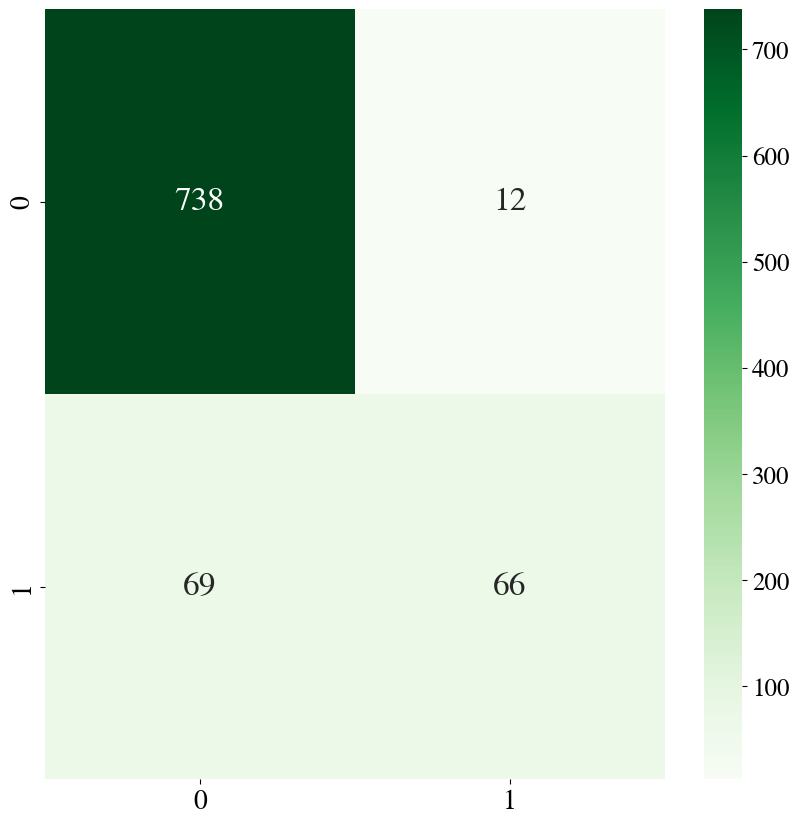

In [405]:
y_pred_best = best_feat_model.predict(df_X_test_full)
plot_confusion_matrix(y_test, y_pred_best,'best')


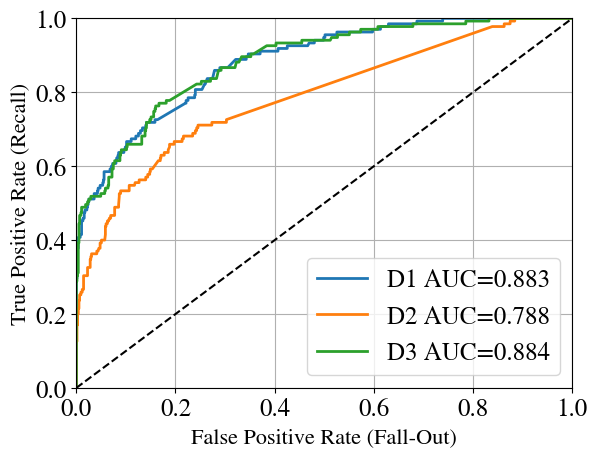

In [403]:
#### PLOTTING THE ROC CURVE OF BOTH CLASSIFIERS ON THE SAME PLOT

y_pred_paper_proba = grid_search_paper.best_estimator_.predict_proba(X_test_paper)[:, 1]
y_pred_full_proba = grid_search_full.best_estimator_.predict_proba(X_test_full)[:, 1]

fpr_paper, tpr_paper, thresholds_paper = roc_curve(y_test_paper,y_pred_paper_proba)    
auc_score_paper = roc_auc_score(y_test_paper,y_pred_paper_proba)

fpr_full, tpr_full, thresholds_full = roc_curve(y_test_full,y_pred_full_proba)    
auc_score_full = roc_auc_score(y_test_full,y_pred_full_proba)

fpr_best, tpr_best, thresholds_full = roc_curve(y_test_full,y_pred_proba_best)    
auc_score_best = roc_auc_score(y_test_full,y_pred_proba_best)


plt.plot(fpr_full, tpr_full, linewidth=2, label=r'D1 AUC={:.3f}'.format(auc_score_full))
plt.plot(fpr_paper, tpr_paper, linewidth=2, label=r'D2 AUC={:.3f}'.format(auc_score_paper))
plt.plot(fpr_best, tpr_best, linewidth=2, label=r'D3 AUC={:.3f}'.format(auc_score_best))

plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])                                    
plt.xlabel(r'False Positive Rate (Fall-Out)', fontsize=16) 
plt.ylabel(r'True Positive Rate (Recall)', fontsize=16)
plt.legend(loc='best',fontsize=18)
plt.grid(True)                                            
plt.savefig(r'comparison_roc_curve_best.png')
plt.show()





In [397]:
import pickle
pickle.dump(best_feat_model, open('best_feat_model.pkl', 'wb'))

In [400]:
df_dataset_full[['address']+best_features_set+['target']].to_csv('best_dataset.csv',index=False)

In [469]:
best_per_set = df_cross_validations[df_cross_validations.rank_test_score == 1][['n_features','mean_test_score','std_test_score']].copy()

In [470]:
best_per_set

,n_features,mean_test_score,std_test_score
667,27,0.890530,0.010008
559,26,0.890431,0.009021
706,25,0.891103,0.008805
469,24,0.891220,0.007833
447,23,0.891043,0.010547
439,22,0.889774,0.007588
424,21,0.889571,0.008475
406,20,0.891165,0.007548
430,19,0.889720,0.008432
343,18,0.888507,0.008352


In [484]:
yerr

[667    0.880522
 559    0.881410
 706    0.882298
 469    0.883387
 447    0.880496
 439    0.882187
 424    0.881096
 406    0.883617
 430    0.881288
 343    0.880155
 352    0.878436
 670    0.876967
 246    0.877624
 589    0.876818
 567    0.876013
 396    0.877197
 382    0.875608
 dtype: float64,
 667   -0.880522
 559   -0.881410
 706   -0.882298
 469   -0.883387
 447   -0.880496
 439   -0.882187
 424   -0.881096
 406   -0.883617
 430   -0.881288
 343   -0.880155
 352   -0.878436
 670   -0.876967
 246   -0.877624
 589   -0.876818
 567   -0.876013
 396   -0.877197
 382   -0.875608
 dtype: float64]

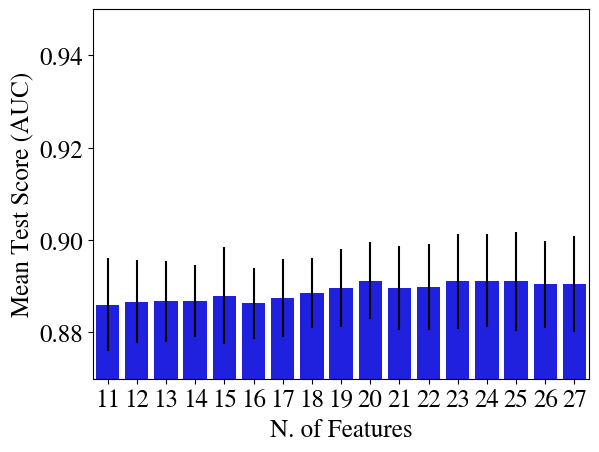

In [503]:
sns.color_palette("muted")
yerr = best_per_set['std_test_score']
sns.barplot(x='n_features',y='mean_test_score',data=best_per_set,yerr=yerr,color='blue')
# plt.grid()
plt.ylabel('Mean Test Score (AUC)')
plt.xlabel('N. of Features')
plt.ylim((0.87,0.95))
plt.savefig('cv_results_features.png')

In [492]:
np.array([best_per_set['mean_test_score']-best_per_set['std_test_score'], best_per_set['mean_test_score']+best_per_set['std_test_score']]).shape

(2, 17)

In [494]:
best_per_set['n_features'].shape

(17,)

<ErrorbarContainer object of 3 artists>

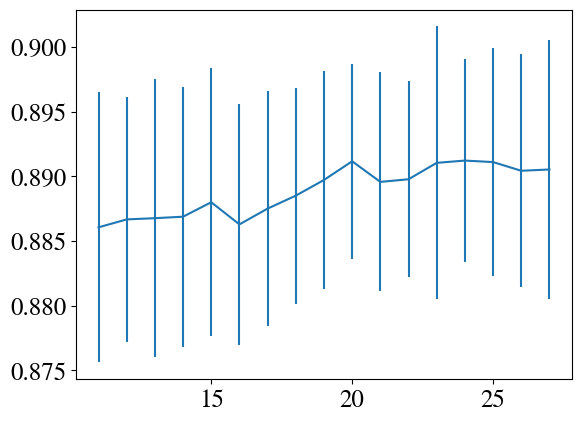

In [504]:
plt.errorbar(x=best_per_set['n_features'],y=best_per_set['mean_test_score'],yerr=yerr )

In [495]:
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)


<ErrorbarContainer object of 3 artists>

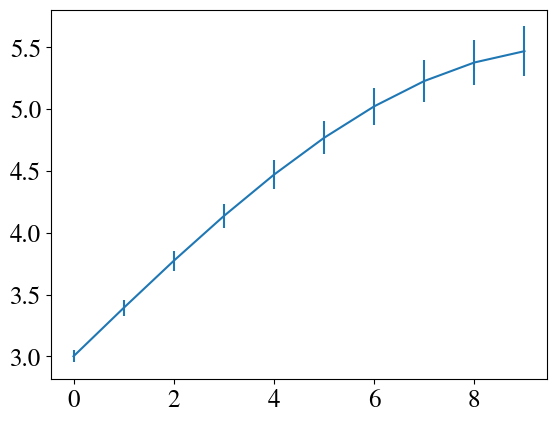

In [500]:
plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')


In [ ]:
from sklearn.decomposition import PCA

In [409]:
pca.n_components_

1

In [415]:
df_X_train_full.columns

Index(['balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
       'investment_to_contract/tx_in', 'payment_from_contract/tx_out',
       '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1',
       'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate', 'paid_one',
       'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out',
       'sdev_tx_out', 'known_rate', 'owner_gets_eth_Wo_investing', 'skew_v1',
       'N_maxpayment', 'skew_v2'],
      dtype='object')

In [421]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(df_X_train_full)
df_X_train_full_scaled = pd.DataFrame(X_train_full_scaled,columns = df_X_train_full.columns)

In [449]:
pca = PCA()
pca.fit(df_X_train_full_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

#find the number of components needed to cover the 0.95 of the variance

d = np.argmax(cumsum >= 0.95) + 1

In [450]:
print('How many components do we need to have 95% of the variance? {}'.format(d))

How many components do we need to have 95% of the variance? 17


In [451]:
pca = PCA(n_components=0.95)

X_reduced = pca.fit_transform(df_X_train_full_scaled)

print('How many components? '.format(pca.n_components_))

print('Explained variance {:.2f}'.format(np.sum(pca.explained_variance_ratio_)))
df_components_feats = pd.DataFrame(pca.components_,columns=pca.feature_names_in_).T


How many components? 
Explained variance 0.95


In [454]:
df_components_feats[[1]].sort_values(1)

,1
known_rate,-0.391195
payment_from_contract/tx_out,-0.358576
paid_one,-0.354648
investment_to_contract/tx_in,-0.272649
percentage_some_tx_out,-0.268470
owner_gets_eth_Wo_investing,-0.212574
mean_v2,-0.164202
mean_v1,-0.158665
percentage_some_tx_in,0.013926
paid_rate,0.023563


In [22]:
data = {}
path = '../paper_3_features'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
target_path = glob.glob(path+"/target*.csv")[0]
data = {'test':path}
dataset = pd.read_csv(dataset_path, header = 0)
data['n.columns'] = [dataset.shape[1]]
data['n.rows'] = [dataset.shape[0]]

# leggo il dataset ed il target

features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1

print(pairs_number_features)

target = pd.read_csv(target_path, header = 0)

_tmp_ = pd.concat([dataset,target],axis=1).drop_duplicates(subset='address')

X = _tmp_.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = _tmp_.iloc[:, -1:].values

print(X.shape,y.shape,_tmp_.columns)

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

params =[
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__criterion' : ['entropy', 'gini'],
        'classifier__max_depth' : [5, 6, 7, 8, 9],
        'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
        'classifier__max_features' : range(6,X_train.shape[1],3),
        'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators':[150, 175, 200, 225, 250],
        'classifier__min_samples_split' : [5,15,30],
        'classifier__criterion':['gini', 'entropy'],
        'classifier__class_weight' : [{0:1, 1:5.5}],
        'classifier__bootstrap': [True, False]
    },
#     {
#         'classifier': [SVC(random_state=42,probability=True)],            
#         'classifier__kernel' : ["poly"],
#         'classifier__C' : [0.1,1,5,10],
#         'classifier__coef0' : [1,0.8],
#         'classifier__gamma': ['auto']

#     },
    {
        'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
        'classifier__learning_rate' : [0.1,0.01],
        'classifier__n_estimators' : [80, 100, 120],
        'classifier__max_depth' : [10,15,20],
        'classifier__colsample_bytree' : [0.5,0.8,1],
        'classifier__reg_alpha' : [0, 0.1, 0.2],
        'classifier__reg_lambda' : [1,10,15]
    }



     ]
grid_search = GridSearchCV(pipeline, params, cv=3,
                           scoring='roc_auc',
                           return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())


[(0, 'balance'), (1, 'N_maxpayment'), (2, 'investment_in'), (3, 'payment_out'), (4, 'mean_v1'), (5, 'sdev_v1'), (6, 'skew_v1'), (7, 'mean_v2'), (8, 'sdev_v2'), (9, 'skew_v2'), (10, 'known_rate'), (11, 'paid_rate'), (12, 'paid_one')]
(4422, 13) (4422, 1) Index(['address', 'balance', 'N_maxpayment', 'investment_in', 'payment_out',
       'mean_v1', 'sdev_v1', 'skew_v1', 'mean_v2', 'sdev_v2', 'skew_v2',
       'known_rate', 'paid_rate', 'paid_one', 'target'],
      dtype='object')
Number of smart contract in train set:: 2999
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 750
Number of smart Ponzi in test set:: 135
Fitting 3 folds for each of 726 candidates, totalling 2178 fits
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(rand

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), class


[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_stat

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=6, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=175; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier=RandomForestClas

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; t


[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=5, classifier__n_estimators=250; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=entropy, classifier__min_samples_split=15, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier=Ra

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; to

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15;

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambd

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total tim

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; t

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [DecisionTreeClassifier(random_state=42)],
                          'classifier__class_weight': [{0: 1, 1: 4},
                                                       {0: 1, 1: 4.5}],
                          'classifier__criterion': ['entropy', 'gini'],
                          'classifier__max_depth': [5, 6, 7, 8, 9],
                          'classifier__max_features': range(6, 13, 3),
                          '...
                                                        max_depth=15, n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0.1,
                                                        reg_lambda=10)],
                          'classifier__colsample_bytree':

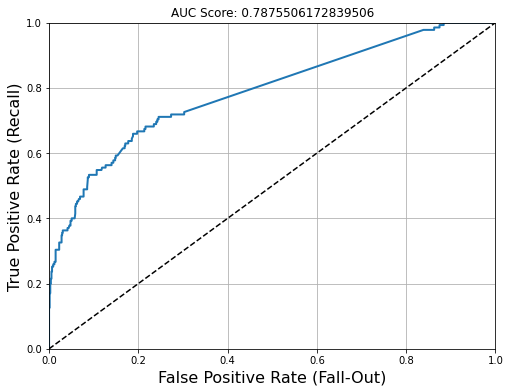

DecisionTreeClassifier
RandomForestClassifier
LGBMClassifier


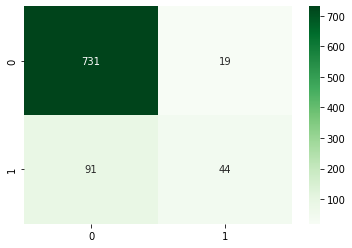

     (Number, Feature)  Importance
0         (8, sdev_v2)         402
1         (4, mean_v1)         305
2         (9, skew_v2)         276
3     (3, payment_out)         256
4         (5, sdev_v1)         241
5      (11, paid_rate)         241
6         (0, balance)         227
7   (2, investment_in)         203
8         (7, mean_v2)         201
9         (6, skew_v1)         195
10      (12, paid_one)         181
11   (1, N_maxpayment)         148
12    (10, known_rate)          76


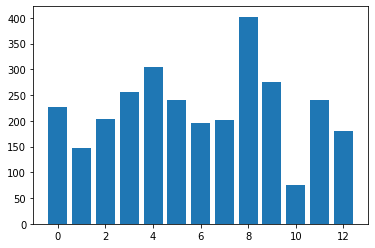

In [23]:
data['best hyperparameters'] = [grid_search.best_params_]
data['best score'] = [grid_search.best_score_]

y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]    

# Confusion matrix 
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
auc_score = roc_auc_score(y_test,y_pred_proba)

data['best_auc_score_test'] = auc_score

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, auc_score)

# grid_search.fit(X_train, y_train.ravel())
df_cv = pd.DataFrame(grid_search.cv_results_)
best_classifiers_cv(df_cv,data,X_train,y_train,X_test,y_test)

cm = confusion_matrix(y_test, y_pred)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')
plt.show()

data['tn'] = [tn]
data['fp'] = [fp]
data['fn'] = [fn]
data['tp'] = [tp]

features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))

for i,feat in enumerate(sorted_dict.keys()):
    data['feat_{}'.format(i)] = [feat]
    if i == 5:
        break

print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

# _tmp = pd.DataFrame.from_dict(data)
# df = pd.concat([df,_tmp])

In [26]:
grid_search.best_estimator_.named_steps['classifier'].feature_importances_

array([227, 148, 203, 256, 305, 241, 195, 201, 402, 276,  76, 241, 181],
      dtype=int32)

Do new features increase the performance of a classifier? --> the difference of the performance are statistically significant?

In [30]:
data = {}
path = '../dataset full/'
dataset_path = glob.glob(path+"/dataset*.csv")[0]
target_path = glob.glob(path+"/target*.csv")[0]
data = {'test':path}
dataset = pd.read_csv(dataset_path, header = 0)
data['n.columns'] = [dataset.shape[1]]
data['n.rows'] = [dataset.shape[0]]

# leggo il dataset ed il target

features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1

print(pairs_number_features)

target = pd.read_csv(target_path, header = 0)

_tmp_ = pd.concat([dataset,target],axis=1).drop_duplicates(subset='address')

X = _tmp_.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = _tmp_.iloc[:, -1:].values

print(X.shape,y.shape,_tmp_.columns)

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

params =[
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__criterion' : ['entropy', 'gini'],
        'classifier__max_depth' : [5, 6, 7, 8, 9],
        'classifier__min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
        'classifier__max_features' : range(6,X_train.shape[1],3),
        'classifier__class_weight' : [{0:1, 1:4}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators':[150, 175, 200, 225, 250],
        'classifier__min_samples_split' : [5,15,30],
        'classifier__criterion':['gini', 'entropy'],
        'classifier__class_weight' : [{0:1, 1:5.5}],
        'classifier__bootstrap': [True, False]
    },
#     {
#         'classifier': [SVC(random_state=42,probability=True)],            
#         'classifier__kernel' : ["poly"],
#         'classifier__C' : [0.1,1,5,10],
#         'classifier__coef0' : [1,0.8],
#         'classifier__gamma': ['auto']

#     },
    {
        'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
        'classifier__learning_rate' : [0.1,0.01],
        'classifier__n_estimators' : [80, 100, 120],
        'classifier__max_depth' : [10,15,20],
        'classifier__colsample_bytree' : [0.5,0.8,1],
        'classifier__reg_alpha' : [0, 0.1, 0.2],
        'classifier__reg_lambda' : [1,10,15]
    }



     ]
grid_search = GridSearchCV(pipeline, params, cv=3,
                           scoring='roc_auc',
                           return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())


[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'tx_out'), (4, 'investment_in'), (5, 'payment_out'), (6, 'investment_to_contract/tx_in'), (7, 'payment_from_contract/tx_out'), (8, '#addresses_paying_contract'), (9, '#addresses_paid_by_contract'), (10, 'mean_v1'), (11, 'sdev_v1'), (12, 'mean_v2'), (13, 'sdev_v2'), (14, 'paid_rate'), (15, 'paid_one'), (16, 'percentage_some_tx_in'), (17, 'sdev_tx_in'), (18, 'percentage_some_tx_out'), (19, 'sdev_tx_out'), (20, 'known_rate'), (21, 'owner_gets_eth_Wo_investing'), (22, 'owner_gets_eth_investing'), (23, 'owner_no_eth'), (24, 'skew_v1'), (25, 'N_maxpayment'), (26, 'skew_v2')]
(4422, 27) (4422, 1) Index(['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
       'payment_out', 'investment_to_contract/tx_in',
       'payment_from_contract/tx_out', '#addresses_paying_contract',
       '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2',
       'sdev_v2', 'paid_rate', 'paid_one', 'percentage_some_tx_in',
       'sdev

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.0s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; 

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_s

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=6, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_stat

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=entropy, classifier__max_depth=9, classifier__max_features=24, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cla

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=9, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), cla

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=18, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=18, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=18, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=5, classifier__max_features=21, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifie

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=12, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=7, classifier__max_features=15, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifie

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=18, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=18, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=entropy, classifier__max_depth=8, classifier__max_features=18, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=5, classifier__max_features=12, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_stat

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=6, classifier__max_features=24, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=9, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=7, classifier__max_features=24, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=8, classifier__max_features=6, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_stat

[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=21, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=21, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=21, classifier__min_samples_split=10; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=42), classifier__class_weight={0: 1, 1: 4.5}, classifier__criterion=gini, classifier__max_depth=9, classifier__max_features=21, classifier__min_samples_split=15; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_st

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=150; total time=   0.4s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=175; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=175; total time=   0.5s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=True, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=175; total time=   0.5s
[CV] END classifier=RandomForestClas

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=175; total time=   0.7s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=30, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier=RandomForest

[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=225; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=225; total time=   0.8s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.9s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__bootstrap=False, classifier__class_weight={0: 1, 1: 5.5}, classifier__criterion=gini, classifier__min_samples_split=15, classifier__n_estimators=250; total time=   0.9s
[CV] END classifier=RandomForest

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_l

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.5, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lam

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lamb

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_l

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=15; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=10; 

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; to

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.2s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; tota

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=10, classifier__n_estimators=100, classifier__reg_alpha=0.2, classifier__reg_lambda

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [DecisionTreeClassifier(random_state=42)],
                          'classifier__class_weight': [{0: 1, 1: 4},
                                                       {0: 1, 1: 4.5}],
                          'classifier__criterion': ['entropy', 'gini'],
                          'classifier__max_depth': [5, 6, 7, 8, 9],
                          'classifier__max_features': range(6, 27, 3),
                          '...
                                                        n_estimators=80,
                                                        n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0.2,
                                                        reg_lambda=1)],

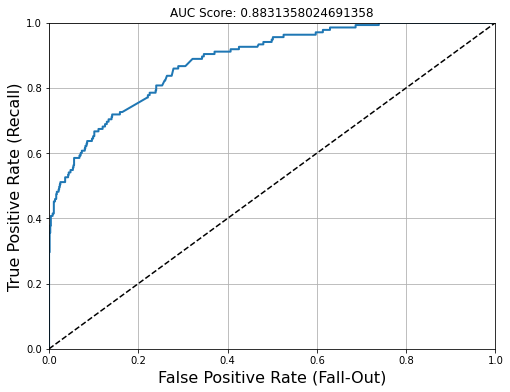

DecisionTreeClassifier
RandomForestClassifier
LGBMClassifier


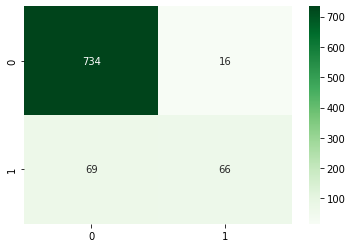

                    (Number, Feature)  Importance
0                    (17, sdev_tx_in)         230
1                          (2, tx_in)         219
2                       (1, lifetime)         210
3         (16, percentage_some_tx_in)         195
4                       (13, sdev_v2)         176
5   (6, investment_to_contract/tx_in)         172
6                       (10, mean_v1)         149
7                       (26, skew_v2)         108
8                        (0, balance)          99
9                       (11, sdev_v1)          97
10       (18, percentage_some_tx_out)          96
11                     (15, paid_one)          78
12                      (24, skew_v1)          77
13                    (14, paid_rate)          62
14   (9, #addresses_paid_by_contract)          59
15                   (20, known_rate)          53
16                  (19, sdev_tx_out)          50
17                 (25, N_maxpayment)          46
18                      (12, mean_v2)          45


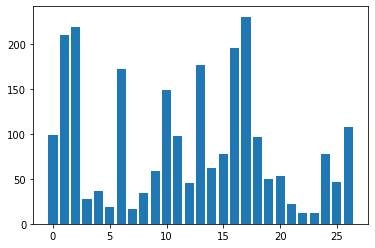

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0, classifier__reg_lambda=1; t

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; to

In [31]:
data['best hyperparameters'] = [grid_search.best_params_]
data['best score'] = [grid_search.best_score_]

y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]    

# Confusion matrix 
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
auc_score = roc_auc_score(y_test,y_pred_proba)

data['best_auc_score_test'] = auc_score

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, auc_score)

# grid_search.fit(X_train, y_train.ravel())
df_cv = pd.DataFrame(grid_search.cv_results_)
best_classifiers_cv(df_cv,data,X_train,y_train,X_test,y_test)

cm = confusion_matrix(y_test, y_pred)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')
plt.show()

data['tn'] = [tn]
data['fp'] = [fp]
data['fn'] = [fn]
data['tp'] = [tp]

features_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))

for i,feat in enumerate(sorted_dict.keys()):
    data['feat_{}'.format(i)] = [feat]
    if i == 5:
        break

print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

# _tmp = pd.DataFrame.from_dict(data)
# df = pd.concat([df,_tmp])

The performance are statistically significative? 

Which is the best set of features among the ones described above? --> Description of the remanining features, what they focus on?

In [47]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


df_X_train = pd.DataFrame(X_train,columns=features_names)
df_X_test = pd.DataFrame(X_test,columns=features_names)

model = grid_search.best_estimator_.named_steps['classifier']

# rfe = RFE(model)
# rfe = rfe.fit(df_X_train, y_train.ravel())

# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)
# print(rfe.get_feature_names_out())

In [54]:
auc_scores = {'n_features':[],'auc_score':[]}
for i in range(len(df_X_train.columns),len(df_X_train.columns)//2,-1):
    rfe = RFE(model,n_features_to_select=i)
    rfe = rfe.fit(df_X_train, y_train.ravel())

# summarize the selection of the attributes
#     print(rfe.support_)
#     print(rfe.ranking_)
    print(rfe.get_feature_names_out())
    X_train_transformed = rfe.transform(df_X_train)
    X_test_transformed = rfe.transform(df_X_test)
    model.fit(X_train_transformed,y_train.ravel())
    y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)    
    auc_score = roc_auc_score(y_test,y_pred_proba)
    print(auc_score)
    auc_scores['n_features'].append(i)
    auc_scores['auc_score'].append(auc_score)

['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_out'
 'investment_to_contract/tx_in' 'payment_from_contract/tx_out'
 '#addresses_paying_contract' '#addresses_paid_by_contract' 'mean_v1'
 'sdev_v1' 'mean_v2' 'sdev_v2' 'paid_rate' 'paid_one'
 'percentage_some_tx_in' 'sdev_tx_in' 'percentage_some_tx_out'
 'sdev_tx_out' 'known_rate' 'owner_gets_eth_Wo_investing'
 'owner_gets_eth_investing' 'owner_no_eth' 'skew_v1' 'N_maxpayment'
 'skew_v2']
0.8831358024691358
['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_out'
 'investment_to_contract/tx_in' 'payment_from_contract/tx_out'
 '#addresses_paying_contract' '#addresses_paid_by_contract' 'mean_v1'
 'sdev_v1' 'mean_v2' 'sdev_v2' 'paid_rate' 'paid_one'
 'percentage_some_tx_in' 'sdev_tx_in' 'percentage_some_tx_out'
 'sdev_tx_out' 'known_rate' 'owner_gets_eth_Wo_investing'
 'owner_gets_eth_investing' 'skew_v1' 'N_maxpayment' 'skew_v2']
0.8770518518518519
['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_

In [55]:
df_auc_scores = pd.DataFrame(auc_scores)

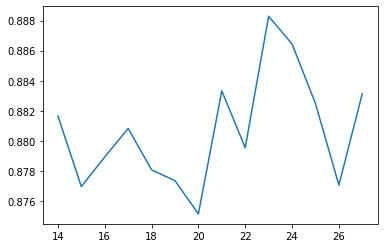

In [56]:
df_auc_scores = pd.DataFrame(auc_scores)
plt.plot(df_auc_scores['n_features'],df_auc_scores['auc_score'])

In [68]:
from sklearn.base import BaseEstimator

class shrinking_columns(BaseEstimator):
    def __init__(self, list_columns=None): # no *args or **kargs
        self.list_columns = list_columns ## this is the only hyperparameter that we would like to tune.
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        if self.list_columns == None: 
            return X
        else:
            return X.loc[:,self.list_columns]

In [67]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [74]:
num_pipeline = Pipeline([
        ('selector', shrinking_columns(list_columns=['balance','lifetime','skew_v2'])),
    ])

In [76]:
num_pipeline.fit_transform(df_X_train)

,balance,lifetime,skew_v2
0,0.00000,784.0,0.000000
1,0.00000,8.0,50.810122
2,0.02000,69.0,-0.000204
3,0.00000,7.0,0.000000
4,0.00000,0.0,0.670284
...,...,...,...
3532,0.00000,3.0,0.000000
3533,0.00000,1.0,0.000000
3534,0.00711,0.0,0.000000
3535,0.00000,115.0,0.000000


['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_out'
 'investment_to_contract/tx_in' 'payment_from_contract/tx_out'
 '#addresses_paying_contract' '#addresses_paid_by_contract' 'mean_v1'
 'sdev_v1' 'mean_v2' 'sdev_v2' 'paid_rate' 'paid_one'
 'percentage_some_tx_in' 'sdev_tx_in' 'percentage_some_tx_out'
 'sdev_tx_out' 'known_rate' 'owner_gets_eth_Wo_investing'
 'owner_gets_eth_investing' 'owner_no_eth' 'skew_v1' 'N_maxpayment'
 'skew_v2']
0.9811080149393043
['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_out'
 'investment_to_contract/tx_in' 'payment_from_contract/tx_out'
 '#addresses_paying_contract' '#addresses_paid_by_contract' 'mean_v1'
 'sdev_v1' 'mean_v2' 'sdev_v2' 'paid_rate' 'paid_one'
 'percentage_some_tx_in' 'sdev_tx_in' 'percentage_some_tx_out'
 'sdev_tx_out' 'known_rate' 'owner_gets_eth_Wo_investing'
 'owner_gets_eth_investing' 'skew_v1' 'N_maxpayment' 'skew_v2']
0.9817934974607396
['balance' 'lifetime' 'tx_in' 'tx_out' 'investment_in' 'payment_

In [123]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(1)['features'].values

array(['balance,lifetime,tx_in,tx_out,investment_in,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,#addresses_paid_by_contract,mean_v1,sdev_v1,mean_v2,sdev_v2,paid_rate,paid_one,percentage_some_tx_in,sdev_tx_in,percentage_some_tx_out,sdev_tx_out,known_rate,owner_gets_eth_Wo_investing,skew_v1,N_maxpayment,skew_v2'],
      dtype=object)

In [99]:
sorted_cross_validations = df_cross_validations.sort_values('mean_test_score',ascending=False).reset_index().copy()

In [265]:
sorted_cross_validations.head(1).features.values

array(['balance,lifetime,tx_in,tx_out,investment_in,investment_to_contract/tx_in,payment_from_contract/tx_out,#addresses_paying_contract,#addresses_paid_by_contract,mean_v1,sdev_v1,mean_v2,sdev_v2,paid_rate,paid_one,percentage_some_tx_in,sdev_tx_in,percentage_some_tx_out,sdev_tx_out,known_rate,owner_gets_eth_Wo_investing,skew_v1,N_maxpayment,skew_v2'],
      dtype=object)

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.1, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda=15; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=15, classifier__n_estimators=120, classifier__reg_alpha=0.2, classifier__reg_lambda

[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=80, classifier__reg_alpha=0.2, classifier__reg_lambda=1; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0, classifier__reg_lambda=10; total time=   0.1s
[CV] END classifier=LGBMClassifier(n_jobs=4, random_state=42), classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__n_estimators=100, classifier__reg_alpha=0.1, classifier__reg_lambda=1; to

In [102]:
sorted_cross_validations['n_features'].value_counts()

26    966
25    966
27    966
24    906
22    906
23    906
20    846
21    846
19    846
17    786
18    786
16    786
15    726
13    726
14    726
12    666
11    666
Name: n_features, dtype: int64

In [112]:
sorted_cross_validations['params']

0        {'classifier': LGBMClassifier(colsample_bytree...
1        {'classifier': LGBMClassifier(colsample_bytree...
2        {'classifier': LGBMClassifier(colsample_bytree...
3        {'classifier': LGBMClassifier(colsample_bytree...
4        {'classifier': LGBMClassifier(colsample_bytree...
                               ...                        
14017    {'classifier': DecisionTreeClassifier(random_s...
14018    {'classifier': DecisionTreeClassifier(random_s...
14019    {'classifier': DecisionTreeClassifier(random_s...
14020    {'classifier': DecisionTreeClassifier(random_s...
14021    {'classifier': DecisionTreeClassifier(random_s...
Name: params, Length: 14022, dtype: object

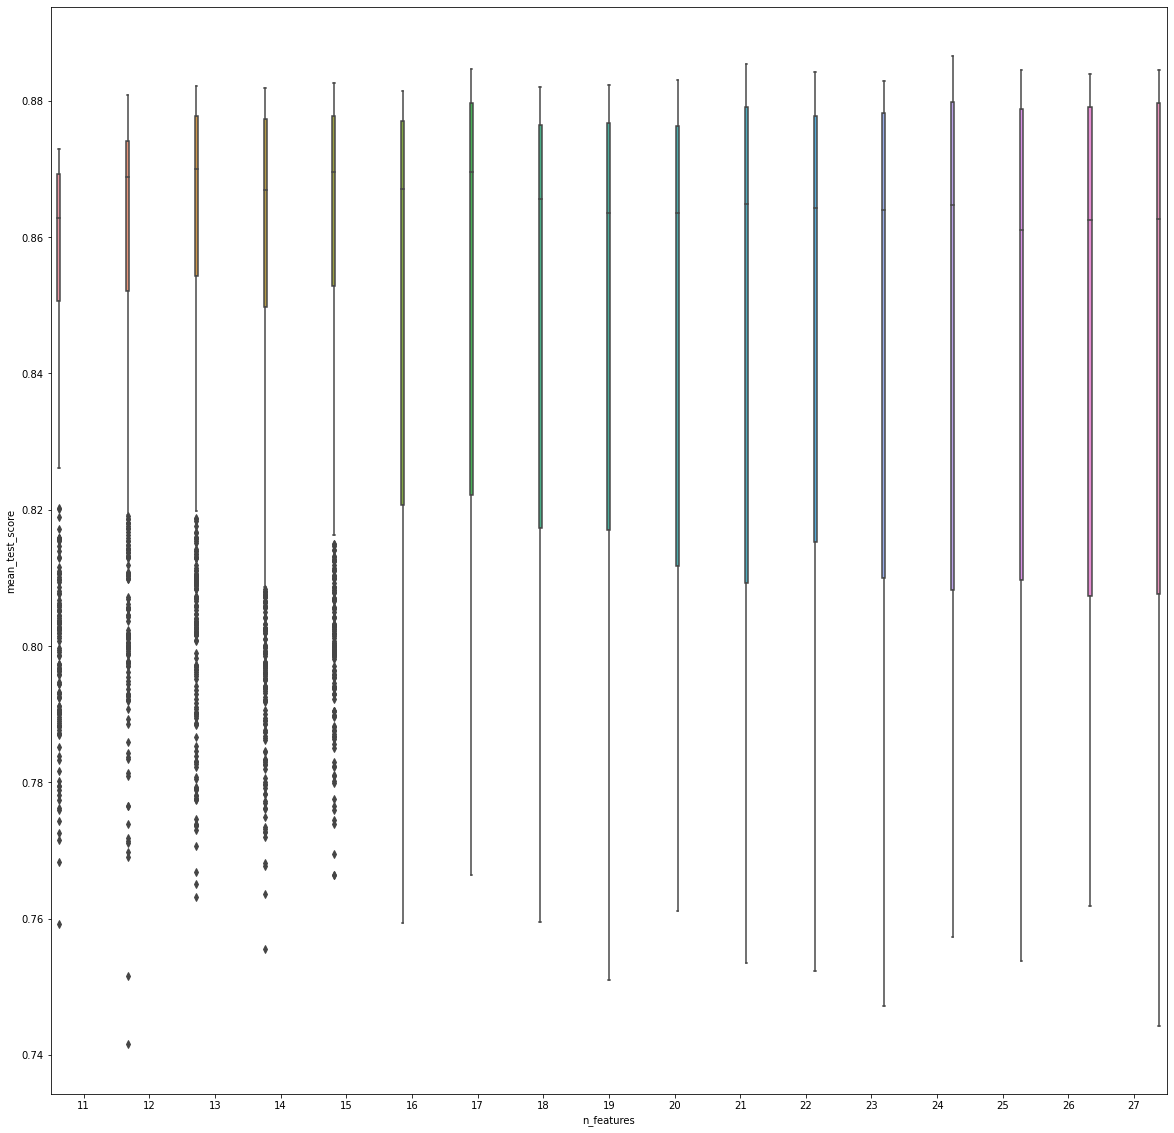

In [122]:
plt.figure(figsize=(20,20))
sns.boxplot(data=sorted_cross_validations,x='n_features',y='mean_test_score',hue='n_features',showfliers = True)
plt.legend([],[], frameon=False)
# plt.ylim((0.84,0.88))

<AxesSubplot:ylabel='mean_test_score'>

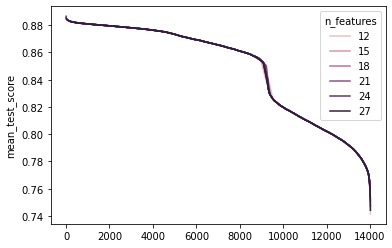

In [101]:
sns.lineplot(x=range(0,len(sorted_cross_validations)),y='mean_test_score',data=sorted_cross_validations,hue='n_features')

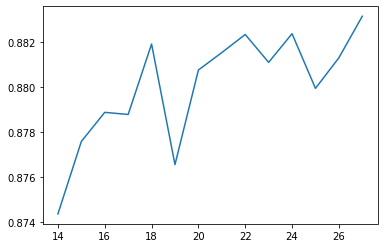

In [62]:
df_auc_scores = pd.DataFrame(auc_scores)
plt.plot(df_auc_scores['n_features'],df_auc_scores['auc_score'])

In [63]:
best_models

{27: (Pipeline(steps=[('classifier',
                   LGBMClassifier(colsample_bytree=0.8, max_depth=20,
                                  n_estimators=80, n_jobs=4, random_state=42,
                                  reg_alpha=0.2, reg_lambda=1))]),
  {'classifier': LGBMClassifier(colsample_bytree=0.8, max_depth=20, n_estimators=80, n_jobs=4,
                  random_state=42, reg_alpha=0.2, reg_lambda=1),
   'classifier__colsample_bytree': 0.8,
   'classifier__learning_rate': 0.1,
   'classifier__max_depth': 20,
   'classifier__n_estimators': 80,
   'classifier__reg_alpha': 0.2,
   'classifier__reg_lambda': 1}),
 26: (Pipeline(steps=[('classifier',
                   LGBMClassifier(colsample_bytree=1, max_depth=20,
                                  n_estimators=80, n_jobs=4, random_state=42,
                                  reg_alpha=0, reg_lambda=1))]),
  {'classifier': LGBMClassifier(colsample_bytree=1, max_depth=20, n_estimators=80, n_jobs=4,
                  random_state=42, r

In [39]:
X_train_transformed = rfe.transform(df_X_train)


In [41]:
X_train_transformed.shape

(3537, 13)